<a href="https://colab.research.google.com/github/taheroo/Delay-Prediction-Tunisair/blob/master/TunisairYesWeCan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Init { form-width: "100px" }

print('----------------------- GLOBAL INIT... -----------------------')

# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import csv
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def getCsv(link, name = '_csv_cache'):
  fluff, id = link.split('=')
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(name)
  return pd.read_csv(name)

def ginic(actual, pred):
    actual = np.asarray(actual) 
    n = len(actual)
    a_s = actual[np.argsort(pred)]
    a_c = a_s.cumsum()
    giniSum = a_c.sum() / a_s.sum() - (n + 1) / 2.0
    return giniSum / n
 
def gini_normalized(a, p):
    if p.ndim == 2:
        p = p[:,1] 
    return ginic(a, p) / ginic(a, a)


def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score

def check_missing_data(data, labels):
  for c in labels:
      no_missing = data[c].isnull().sum()
      if no_missing > 0:
          print(c)
          print(no_missing)
      else:
          print(c)
          print("No missing values")
          print(' ')

def sum_stats(data, console = False, label="Sum"):
  if console:
    unique, counts = np.unique(data, return_counts=True)
    dict(zip(unique, counts))
    return

  sns.countplot(data, label="Sum")
  plt.show()

def correlation_analysis(data):
  correlation = data.corr()

  mask = np.zeros_like(correlation, dtype=np.bool)
  mask[np.triu_indices_from(mask)] = True

  f, ax = plt.subplots(figsize=(20, 20))

  cmap = sns.diverging_palette(180, 20, as_cmap=True)
  sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=1, vmin =-1, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

  plt.show()

def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, center=0, fmt='.2f',
                cmap=sns.diverging_palette(220, 20, as_cmap=True),
                square=True, linewidths=.5, annot=True)
    plt.show();
    

print('----------------------- GLOBAL INIT DONE -----------------------')


----------------------- GLOBAL INIT... -----------------------
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
----------------------- GLOBAL INIT DONE -----------------------


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

# Import data 
train_data = getCsv('https://drive.google.com/open?id=1uGl-V4SGmLokp4hnKurekZH0I9nzO2qR', 'Train.csv')
test_data = getCsv('https://drive.google.com/open?id=19JU_pahUqBo2gZG04fO3ArfcogVRpY9p', 'Test.csv')

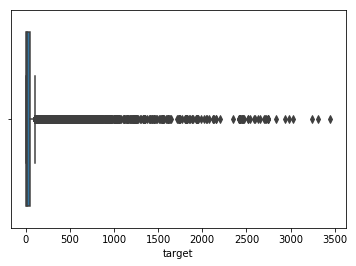

In [0]:
import seaborn as sns
sns.boxplot(x=train_data['target'])

In [0]:
X = train_data.copy()
X['HOURD'] = pd.to_datetime(X['STD'], errors='coerce')
X['HOURD'] = X['HOURD'].dt.hour

#X['MINUTED'] = pd.to_datetime(X['STD'], errors='coerce')
#X['MINUTED'] = X['MINUTED'].dt.minute

X.STA = X.STA.apply(lambda x : x.replace(".", ":"))
#X['HOURA'] = pd.to_datetime(X['STA'], errors='coerce')
#X['HOURA'] = X['HOURA'].dt.hour

X['DAY'] = pd.to_datetime(X['DATOP'], errors='coerce')
X['DAY'] = X['DAY'].dt.dayofweek

X['DAY'].loc[X.DAY <= 4] = 0 
X['DAY'].loc[X.DAY > 4] = 1 

X['MONTH'] = pd.to_datetime(X['DATOP'], errors='coerce')
X['MONTH'] = X['MONTH'].dt.month


X['YEAR'] = pd.to_datetime(X['DATOP'], errors='coerce')
X['YEAR'] = X['YEAR'].dt.year

X = X.drop('DATOP', axis=1)
#X = X.drop('STATUS', axis=1)
X = X.drop('ID', axis=1)
X = X.drop('DEPSTN', axis=1)

X = X.drop('ARRSTN', axis=1)

#X = X.drop('AC', axis=1) # To rethink...


X['CT'] = X.FLTID.apply(lambda x : x.split(" ",1)[0])
X['CT'] = le.fit_transform(X['CT'])
#X['AC'] = le.fit_transform(X['AC'])

X['ACB'] = X.AC.apply(lambda x : x.split(" ",1)[1])
X['ACB'] = le.fit_transform(X['ACB'])

X.FLTID = X.FLTID.apply(lambda x : int(re.search(r'\d+', x.split(" ")[1]).group()))
X.STA = X.STA.apply(lambda x : x.replace(".", ":"))

# Duration
fmt = '%Y-%m-%d %H:%M:%S'
d1_x = X.STD.apply(lambda x : datetime.strptime(x, fmt))
d2_x = X.STA.apply(lambda x : datetime.strptime(x, fmt))

X['DUR'] = (d2_x - d1_x)

X['DUR'] = X['DUR'].apply(lambda x : int(x.total_seconds() / 60.0))
#X = X.drop('DUR', axis=1) # To rethink...
#X = X.drop('CT', axis=1) # To rethink...
X = X.drop('AC', axis=1) # To rethink...

In [0]:
X_testing = test_data.copy()

X_testing['HOURD'] = pd.to_datetime(X_testing['STD'], errors='coerce')
X_testing['HOURD'] = X_testing['HOURD'].dt.hour

#X_testing['MINUTED'] = pd.to_datetime(X_testing['STD'], errors='coerce')
#X_testing['MINUTED'] = X_testing['MINUTED'].dt.minute

X_testing.STA = X_testing.STA.apply(lambda x : x.replace(".", ":"))
#X_testing['HOURA'] = pd.to_datetime(X_testing['STA'], errors='coerce')
#X_testing['HOURA'] = X_testing['HOURA'].dt.hour

X_testing['DAY'] = pd.to_datetime(X_testing['DATOP'], errors='coerce')
X_testing['DAY'] = X_testing['DAY'].dt.dayofweek

X_testing['DAY'].loc[X_testing.DAY <= 4] = 0 
X_testing['DAY'].loc[X_testing.DAY > 4] = 1 

X_testing['MONTH'] = pd.to_datetime(X_testing['DATOP'], errors='coerce')
X_testing['MONTH'] = X_testing['MONTH'].dt.month


X_testing['YEAR'] = pd.to_datetime(X_testing['DATOP'], errors='coerce')
X_testing['YEAR'] = X_testing['YEAR'].dt.year

X_testing = X_testing.drop('DATOP', axis=1)
#X_testing = X_testing.drop('STATUS', axis=1)
X_testing = X_testing.drop('ID', axis=1)
X_testing = X_testing.drop('DEPSTN', axis=1)

X_testing = X_testing.drop('ARRSTN', axis=1)


#X_testing = X_testing.drop('AC', axis=1) # To rethink...


X_testing['CT'] = X_testing.FLTID.apply(lambda x : x.split(" ",1)[0] )
X_testing['CT'] = le.fit_transform(X_testing['CT'])
#X_testing['AC'] = le.fit_transform(X_testing['AC'])
#X_testing = X_testing.drop('CT', axis=1) # To rethink...

X_testing.FLTID = X_testing.FLTID.apply(lambda x : int(re.search(r'\d+', x.split(" ")[1]).group()))

X_testing['ACB'] = X_testing.AC.apply(lambda x : x.split(" ",1)[1])
X_testing['ACB'] = le.fit_transform(X_testing['ACB'])

# Duration
fmt = '%Y-%m-%d %H:%M:%S'
d1_x = X_testing.STD.apply(lambda x : datetime.strptime(x, fmt))
d2_x = X_testing.STA.apply(lambda x : datetime.strptime(x, fmt))


X_testing['DUR'] = (d2_x - d1_x)
X_testing['DUR'] = X_testing['DUR'].apply(lambda x : int(x.total_seconds() / 60.0))
#X_testing = X_testing.drop('DUR', axis=1) # To rethink...

X_testing = X_testing.drop('STD', axis=1)
X_testing = X_testing.drop('STA', axis=1)
X_testing = X_testing.drop('AC', axis=1) # To rethink...
X_testing.head()


,FLTID,STATUS,HOURD,DAY,MONTH,YEAR,CT,ACB,DUR
0,700,ATA,6,2,5,2016,9,13,50
1,395,ATA,15,3,5,2016,9,9,285
2,745,ATA,10,4,5,2016,9,11,145
3,848,ATA,9,2,5,2016,9,2,210
4,635,ATA,9,2,5,2016,9,37,165


In [0]:
X = X.drop('STD', axis=1)
X = X.drop('STA', axis=1)


In [0]:

X['STATUS'] = le.fit_transform(X['STATUS'])
X_testing['STATUS'] = le.fit_transform(X_testing['STATUS'])


In [0]:
X.head()

,FLTID,STATUS,target,HOURD,DAY,MONTH,YEAR,CT,ACB,DUR
0,712,0,260.0,10,1,1,2016,14,34,145
1,757,0,20.0,15,0,1,2016,14,3,110
2,214,0,0.0,4,1,1,2016,14,34,155
3,480,0,0.0,14,1,1,2016,14,49,170
4,338,0,22.0,14,1,1,2016,14,10,80


In [0]:
from scipy import stats
z = np.abs(stats.zscore(X))
threshold = 3
print(np.where(z > 3))


(array([    19,     93,    112, ..., 107814, 107816, 107823]), array([0, 0, 0, ..., 7, 7, 0]))


In [0]:
print(X.shape)
X = X[(z < 5).all(axis=1)]
X.shape

(107833, 10)


(104924, 10)

In [0]:
y = X['target'].copy()
X = X.drop('target', axis=1)

In [0]:
#grouping country by target
#X.groupby("CT").target.mean().sort_values(ascending=False)[:-1].plot.bar()


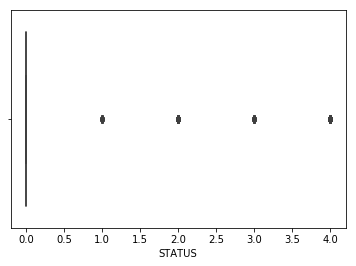

In [0]:
X_testing['STATUS']
sns.boxplot(x=X_testing['STATUS'])

In [0]:
import numpy as np

from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold

import xgboost as xgb

def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

def report_best_scores(results, n_top=3):
  for i in range(1, n_top + 1):
      candidates = np.flatnonzero(results['rank_test_score'] == i)
      for candidate in candidates:
          print("Model with rank: {0}".format(i))
          print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                results['mean_test_score'][candidate],
                results['std_test_score'][candidate]))
          print("Parameters: {0}".format(results['params'][candidate]))
          print("")

          # A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
xgb = xgb.XGBRegressor(objective="reg:linear", random_state=42)


folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X,y), verbose=3, random_state=1001 )



random_search.fit(X, y)

y_test = random_search.predict_proba(X_testing)


print(np.sqrt(mse))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


ValueError: ignored

In [0]:
X.head()

,FLTID,STATUS,HOURD,DAY,MONTH,YEAR,CT,ACB,DUR
0,712,0,10,1,1,2016,14,34,145
1,757,0,15,0,1,2016,14,3,110
2,214,0,4,1,1,2016,14,34,155
3,480,0,14,1,1,2016,14,49,170
4,338,0,14,1,1,2016,14,10,80


In [0]:
output = test_data.copy()
output = pd.DataFrame(output, columns=['ID'])
output['target'] = y_pred.astype(int)
y_pred = y_test
h = output['target'].max()

# Write Output
with open('drive/My Drive/submit.csv', 'w') as writeFile:
    writer = csv.writer(writeFile)
    
    row = ['ID', 'target']
    writer.writerow(row)
    for idx, val in enumerate(y_pred):
      strrow = (str(output['ID'][idx]))
      row = [strrow, output['target'][idx]]
      writer.writerow(row)

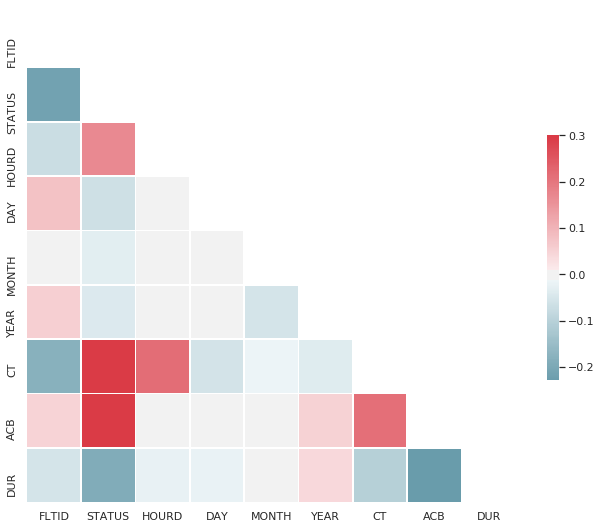

In [0]:

from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")



# Generate a large random dataset
rs = np.random.RandomState(33)
d = X.copy()

# X Encoding
for col in d.columns:
  d[col] = le.fit_transform(d[col])

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [0]:
#@title Preprocessing { form-width: "250px" }

# DATA

from sklearn.preprocessing import LabelEncoder, MinMaxScaler as Scaler
lab_enc = LabelEncoder()
scaler = Scaler()

# Train
x_train_raw = getCsv('https://drive.google.com/open?id=1uGl-V4SGmLokp4hnKurekZH0I9nzO2qR', 'Train.csv')
x_train_raw = transform_data(x_train_raw)
#h


InvalidConfigError: ignored

In [0]:
#@title Saved { form-width: "300px" }
X_Test.head

X_Test = x_test_raw.copy()

# Format Raw Test X
x_test_raw['uniqueid'] = [s.replace('uniqueid_', '') for s in x_test_raw['uniqueid']]
x_test_raw['uniqueid'] = list(map(int, x_test_raw['uniqueid']))

# Encoding
for col in X_Test.columns:
  X_Test[col] = lab_enc.fit_transform(X_Test[col])
X_Test = scaler.fit_transform(X_Test)
X_Test = pd.DataFrame(X_Test, columns = x_test_raw.columns)

# Needed Columns

X_Test = X_Test.drop('uniqueid', axis=1)

######################

# XGBoost Model

from scipy.stats import uniform, randint

from sklearn.metrics import confusion_matrix

import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X, Y.values.ravel())

prediction = xgb_model.predict(X)

#print(confusion_matrix(Y, prediction))

predictions = [round(value) for value in prediction]

# Evaluate Predictions
#accuracy = accuracy_score(Y, predictions)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Test Prediction

prediction = xgb_model.predict(X_Test)

# Write Output
with open('drive/My Drive/submit.csv', 'w') as writeFile:
    writer = csv.writer(writeFile)
    
    row = ['uniqueid', 'bank_account']
    writer.writerow(row)
    for idx, val in enumerate(prediction):
      strrow = 'uniqueid_%s x %s' % (str(x_test_raw['uniqueid'][idx]), x_test_raw['country'][idx])
      row = [strrow, val]
      writer.writerow(row)